# Imports and settings

In [1]:
import numpy as np
import mpmath as mp

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from lib.renormalization.ising import *
from lib.renormalization.utils import *
from lib.matrix_manipulation import matrix_average

In [2]:
mp.mp.dps = 10
mp.mp.pretty = True

# Create model instance

In [3]:
# Create instance
J = 2
H = 0

n = 3
u = 'x'

p = 0.5
N = 500

ising = IsingRenormalizationGroup(J, H, n, u, p, N)

# Renormalization-group flow

In [15]:
%%time

matrices = ising.transfer_matrices

rgflow = []
for k in range(30):
    
    matrices_ = ising.renormalize(matrices)
    j = normalized_tracked_interaction(matrices_, 19)
    rgflow.append(j)
    print(f"k = {k}, Jij/<|J|> = {round(j, 10)}", end="")
    print("\t\t\t", end="\r")
    matrices = matrices_

CPU times: user 32.1 s, sys: 340 ms, total: 32.5 s
Wall time: 33.6 s


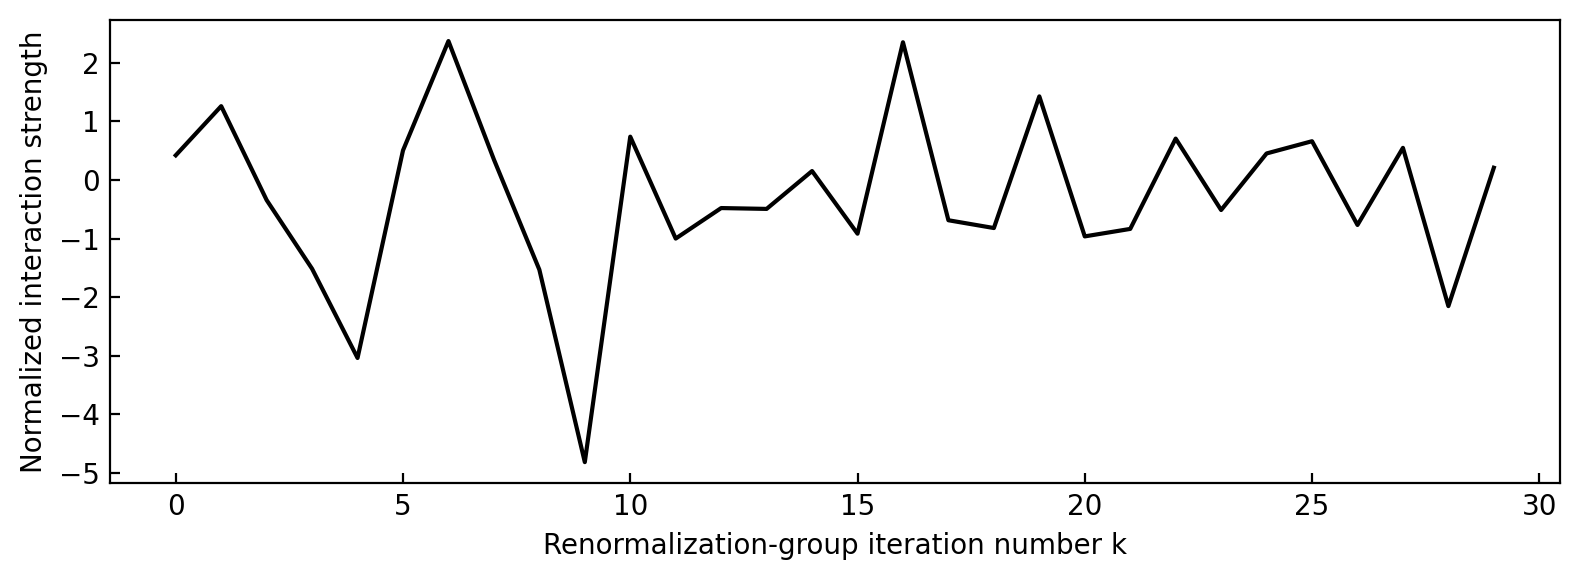

In [17]:
fig, ax = plt.subplots(figsize=(8, 3), layout='tight')
ax.plot(rgflow, ls="-", c="k")
ax.tick_params(axis="both", direction="in")
ax.set_xlabel("Renormalization-group iteration number k")
ax.set_ylabel("Normalized interaction strength")
plt.show()

# Sink distribution

In [18]:
# Extract interactions from transfer matrices
interaction_avr = interaction_absolute_average(matrices)
interactions = []
for i in range(len(matrices)):
    interactions.append(float(interaction(matrices[i]) / interaction_avr))

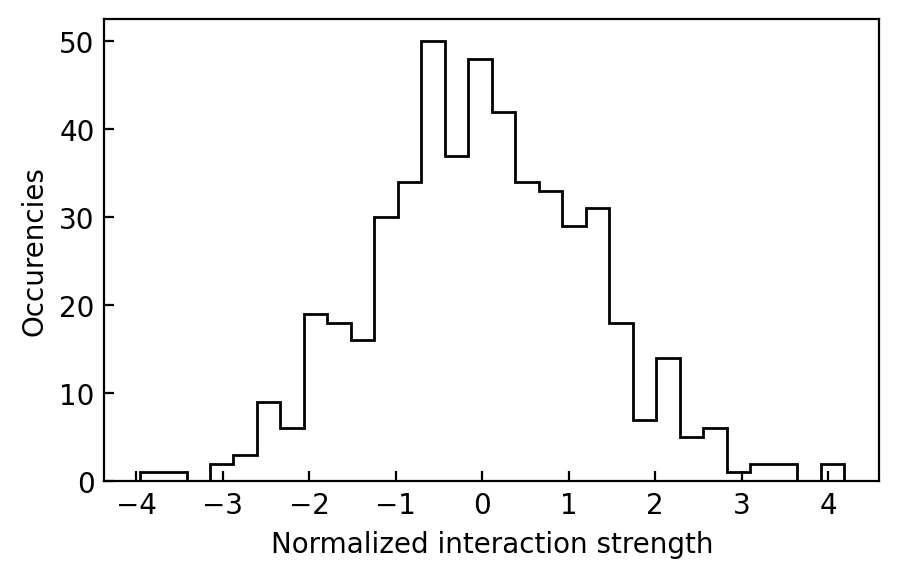

In [19]:
# Plot historam
fig, ax = plt.subplots(figsize=(5, 3))
ax.hist(interactions, bins=30, histtype='step', color='k')
ax.tick_params(axis="both", direction="in", labelsize=10)
ax.set_xlabel("Normalized interaction strength")
ax.set_ylabel("Occurencies")
plt.show()

# Chaos exponents

In [7]:
%%time

rgflow = []
runaway_list = []
lyapunov_list = []
print("k   Jij/<|J|>               <|J'|>/<|J|>             yR                     lambda \n")

matrices = ising.transfer_matrices

for k in range(800):
    
    avr  = interaction_absolute_average(matrices) # <|J|>
    eps = 1e-4 * avr # Deviation
    matrices_, j_normal_, j_deviated_ = ising.renormalize_chaos(matrices, eps)
    avr_  = interaction_absolute_average(matrices_) # <|J'|>
    
    # RG flow
    j = normalized_tracked_interaction(matrices_, 19)
    rgflow.append(j)
    
    # Runaway exponent
    runaway = avr_ / avr
    yR = mp.log(runaway, b=3)
    runaway_list.append([runaway, yR])
    
    # Lyapunov exponent
    j_delta = np.absolute(j_normal_ - j_deviated_)
    derivative = (j_delta / eps) * (avr / avr_)
    ly = mp.log(derivative)
    lyapunov_list.append(ly)
    
    print(f"{k}   {j}    {runaway}    {yR}    {ly}")
    matrices = matrices_

transient = 100 # Transient for chaos
print(f"Runaway exponent  = {np.mean(np.array(runaway_list[transient:])[:,1])}")
print(f"Lyapunov exponent = {np.mean(lyapunov_list[transient:])}")

k   Jij/<|J|>               <|J'|>/<|J|>             yR                     lambda 

0   0.4208754209172554    0.8479450149    -0.1501343904    -1.11002666
1   0.8706721412267566    0.9698753976    -0.02784209872    0.982937166
2   0.26737757580094107    1.056369382    0.04991562384    0.7751073644
3   -1.7390270119266902    1.146593255    0.1245163194    -0.2609980267
4   -1.920219617725108    1.127038403    0.1088585218    0.8433697601
5   0.30309642981958784    1.173701705    0.1457862856    0.8918046703
6   2.354140104945931    1.306139823    0.2431031307    -0.9846214301
7   0.341905163322508    1.368518622    0.2855683119    -2.207402954
8   0.26784688753497754    1.24468809    0.1992376842    1.188276922
9   -0.0040441104582384065    1.338755936    0.2655538987    -1.774960685
10   1.1901313428135825    1.27390596    0.2203577573    1.380423885
11   0.8459739831913489    1.233620307    0.191107625    0.3812860301
12   -4.4568816873835475    1.288954248    0.231047142    -0.77086

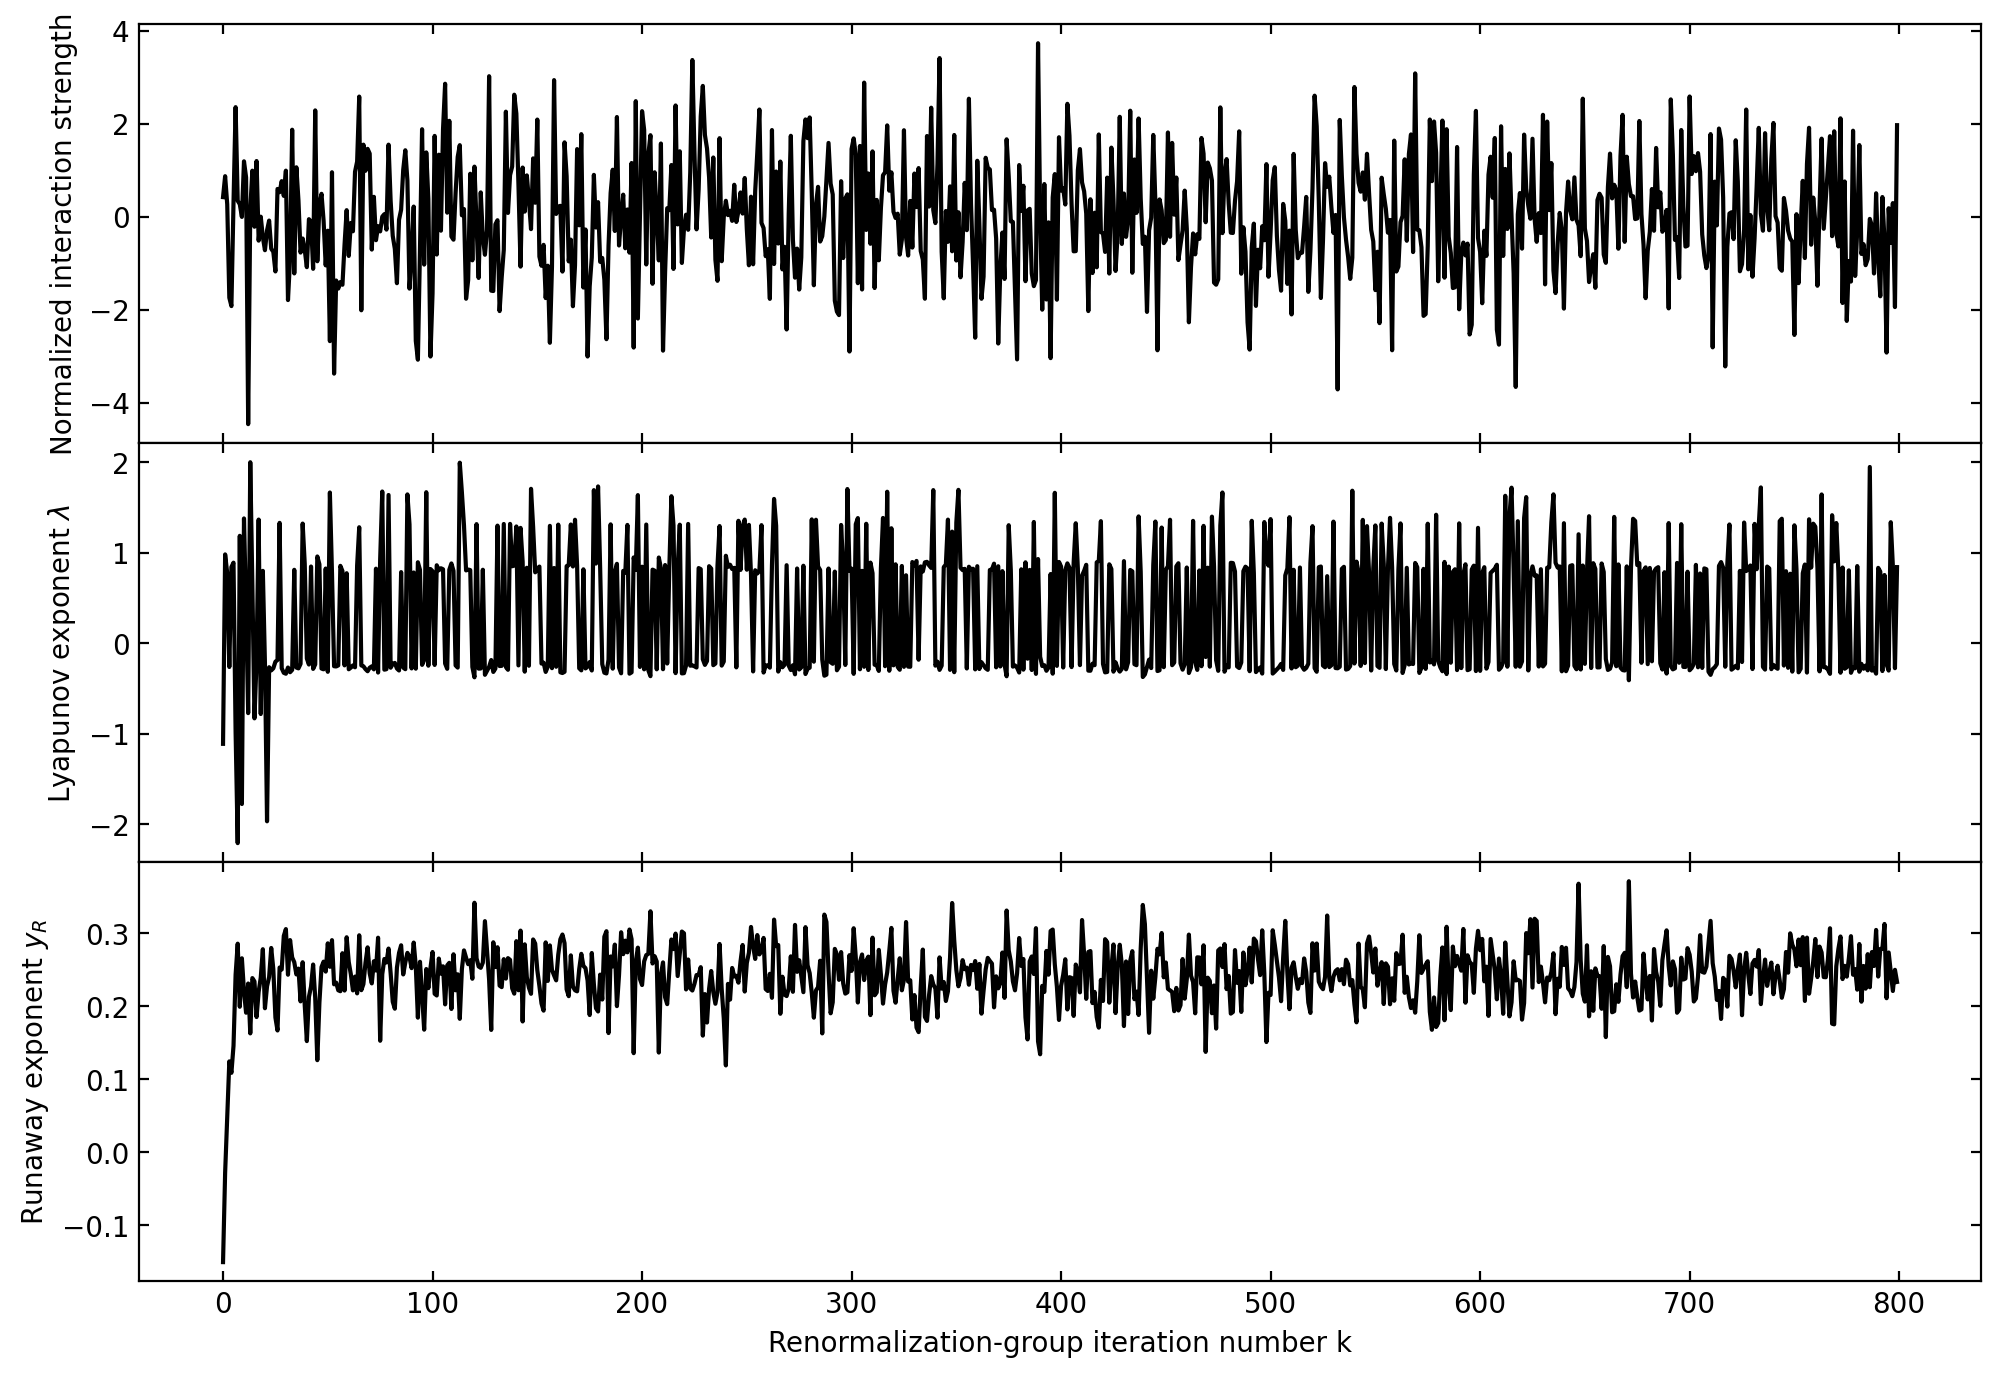

In [8]:
fig, ax = plt.subplots(nrows = 3,
                       ncols = 1, figsize = (10, 7))

ax[0].plot(rgflow, ls="-", c="k")
ax[0].tick_params(axis="both", direction="in", labelbottom=False, labeltop=False, labelleft=True, labelright=False, bottom=True, top=True, left=True, right=True)
ax[0].set_ylabel("Normalized interaction strength")

ax[1].plot(lyapunov_list, ls="-", c="k")
ax[1].tick_params(axis="both", direction="in", labelbottom=False, labeltop=False, labelleft=True, labelright=False, bottom=True, top=True, left=True, right=True)
ax[1].set_ylabel(r"Lyapunov exponent $\lambda$")

ax[2].plot(np.array(runaway_list)[:,1], ls="-", c="k")
ax[2].tick_params(axis="both", direction="in", labelbottom=True, labeltop=False, labelleft=True, labelright=False, bottom=True, top=True, left=True, right=True)
ax[2].set_ylabel("Runaway exponent $y_R$")

ax[2].set_xlabel("Renormalization-group iteration number k")

fig.tight_layout()
plt.subplots_adjust(hspace=0.0)
plt.show()